# Prepare

In [1]:
import numpy as np
import pandas as pd
import os
import tqdm.notebook as tqdm
from dataclasses import dataclass,field
import copy
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm
import dill
matplotlib.rcParams['figure.figsize'] = (13,8)
%config InlineBackend.figure_format = 'retina'

In [2]:
from scipy.stats import chisquare

In [3]:
from sklearn.base import MetaEstimatorMixin
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import chi2
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import plot_roc_curve,roc_curve,auc

In [4]:
import tensorflow.keras as keras

In [5]:
@dataclass
class ModelObj:
    model: MetaEstimatorMixin
    i_train: list
    i_test: list
    features: list
    target: str
    def fit(self, ds: pd.DataFrame,  copy_model=True,**kwargs):
        if copy_model:
            self.model = copy.deepcopy(self.model)
        else:
            self.model = model
        self.x_train = ds[self.features].iloc[self.i_train]
        self.x_test = ds[self.features].iloc[self.i_test]
        self.y_train = ds[self.target].iloc[self.i_train]
        self.y_test = ds[self.target].iloc[self.i_test]
        self.model.fit(self.x_train, self.y_train, **kwargs)
        if hasattr(self.model, 'predict_proba'):
            self.predictor = self.model.predict_proba
        else:
            self.predictor = self.model.predict

        self.p_train = self.predictor(self.x_train)
        self.p_test = self.predictor(self.x_test)

    def predict(self,x,**kwargs):
        if type(x) is pd.DataFrame:
            x= x[self.features]
        else:
            x = pd.DataFrame(x,columns=self.features)
        return self.predictor(x,**kwargs)
    
    def save(self,path):
        save_obj = copy.deepcopy(self)
        del save_obj.x_train
        del save_obj.x_test
        del save_obj.y_train
        del save_obj.y_test
        with open(path,'wb') as f:
            dill.dump(save_obj,f)
        
        
@dataclass
class KerasModelObj:
    model: keras.Model
    i_train: list
    i_test: list
    features: list
    target: str
    x_train: pd.DataFrame = field(init=False)
    x_test: pd.DataFrame = field(init=False)
    p_train: np.ndarray = field(init=False)
    p_test: np.ndarray = field(init=False)
    history: keras.callbacks.History = field(init=False)
    def fit(self, ds: pd.DataFrame, train_args=None, copy_model=True):
        if copy_model:
            self.model = keras.models.clone_model(model)
        else:
            self.model = model
        self.x_train = ds[self.features].iloc[self.i_train]
        self.x_test = ds[self.features].iloc[self.i_test]
        self.y_train = ds[self.target].iloc[self.i_train]
        self.y_test = ds[self.target].iloc[self.i_test]
        self.history = self.model.fit(self.x_train,
                                      self.y_train,
                                      validation_data=(self.x_test,
                                                       self.y_test),
                                      **train_args)
        self.p_train = self.model.predict(self.x_train)
        self.p_test = self.model.predict(self.x_test)
    
    def history_plot(self):
        plt.plot(self.history.history['loss'],label='train')
        plt.plot(self.history.history['val_loss'],label='test')
        plt.xlabel('epoch')
        plt.ylabel('loss')
        plt.grid()

def plot_roc(y_true,y_pred,ax=None,label=None,**plot_args):
    ax: plt.Axes = ax or plt.gca()
    label = label or ''
    fpr,tpr,thr=roc_curve(y_true,y_pred)
    label+='(auc={:.2f})'.format(auc(fpr,tpr))
    ax.plot(fpr,tpr,label=label,**plot_args)
    plt.plot([0,1],[0,1],color='black')
    ax.grid(True)
    ax.legend()
    ax.set_xlabel('fpr')
    ax.set_ylabel('tpr')
    ax.set_xlim(0,1)
    ax.set_ylim(0,1)

def chi2_nan(x,y):
    chi_ = []
    p_ = []
    

# Data

In [4]:
files_path = './ivf/'
dataset = []
for i_ in os.listdir(files_path):
    if i_.endswith('.xlsb'):
        dataset.append(os.path.join(files_path,i_))
dataset = [pd.read_excel(x,engine='pyxlsb') for x in tqdm.tqdm(dataset)]

  0%|          | 0/6 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [16]:
dataset_conc=pd.concat(dataset)

In [17]:
dataset_conc.to_hdf(os.path.join(files_path,'dataset.hdf'),key='data')

/home/amir/miniconda3/envs/jupyter/lib/python3.9/site-packages/pandas/core/generic.py:2606: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed-integer,key->block2_values] [items->Index(['Patient Age at Treatment',
       'Total Number of Previous cycles, Both IVF and DI',
       'Total Number of Previous treatments, Both IVF and DI at clinic',
       'Total Number of Previous IVF cycles',
       'Total Number of Previous DI cycles',
       'Total number of previous pregnancies, Both IVF and DI',
       'Total number of IVF pregnancies', 'Total number of DI pregnancies',
       'Total number of live births - conceived through IVF or DI',
       'Total number of live births - conceived through DI',
       'Main Reason for Producing Embroys Storing Eggs',
       'Type of Ovulation Induction', 'Egg Donor Age at Registration',
       'Sperm Donor Age at Registration', 'Type of treatment - IVF or 

# Analysis

In [6]:
dataset = pd.read_hdf('./ivf/dataset.hdf', 'data')
# dataset=dataset.drop(columns=[x for x in dataset.columns if x not in variables])

def col_normalize(name:str):
    name = name.title()
    name = name.replace('-','_')
    name = name.replace(' ','')
    return name

dataset.columns=[col_normalize(x) for x in dataset.columns]

In [19]:
print('total: ',(dataset.YearOfTreatment>=2010).sum())
conditions=(dataset.EggSource=='Patient')&\
            (dataset.SpermFrom=='Partner')&\
            (dataset.TypeOfTreatment_IvfOrDi=='IVF')&\
            (dataset.Pgd==0)&\
            (dataset.PgdTreatment.isna())&\
            (dataset.Pgs.isna())&\
            (dataset.PgsTreatment.isna())&\
            (dataset.YearOfTreatment>=2010)&\
            (dataset.StimulationUsed==1)&\
            (dataset.MainReasonForProducingEmbroysStoringEggs.str.strip()=='Treatment Now')&\
            (dataset.PatientAgeAtTreatment!='999')

print('conditioned:',conditions.sum())

variables=[
    'PatientAgeAtTreatment',
    
    'TotalNumberOfPreviousCycles,BothIvfAndDi',
    'TotalNumberOfIvfPregnancies',
    'TotalNumberOfLiveBirths_ConceivedThroughIvf',
    
    'TypeOfInfertility_FemalePrimary',
    'TypeOfInfertility_FemaleSecondary',
    'TypeOfInfertility_MalePrimary',
    'TypeOfInfertility_MaleSecondary',
    'TypeOfInfertility_CouplePrimary',
    'TypeOfInfertility_CoupleSecondary',
    
    'CauseOfInfertility_TubalDisease',
    'CauseOfInfertility_OvulatoryDisorder',
    'CauseOfInfertility_MaleFactor',
    'CauseOfInfertility_PatientUnexplained',
    'CauseOfInfertility_Endometriosis',
    'CauseOfInfertility_CervicalFactors',
    'CauseOfInfertility_FemaleFactors',
    'CauseOfInfertility_PartnerSpermConcentration',
    'CauseOfInfertility_PartnerSpermMorphology',
    'CausesOfInfertility_PartnerSpermMotility',
    'CauseOfInfertility_PartnerSpermImmunologicalFactors',
    
    'StimulationUsed',
    'EggSource',
    'SpermFrom',
    'FreshCycle',
    'FrozenCycle',
    'EggsThawed',
    'FreshEggsCollected',
    'EggsMixedWithPartnerSperm',
    'EmbryosTransfered'
]


total:  495628
conditioned: 290609


In [20]:
ds = dataset.copy()
# filtering
ds = ds.loc[
    (ds.PatientAgeAtTreatment != '999')
    & (ds.MainReasonForProducingEmbroysStoringEggs.str.strip()=='Treatment Now')
    & (ds.StimulationUsed==1)
    & (ds.DonatedEmbryo==0) 
    & (ds.EggSource=='Patient')
    & (ds.SpermFrom=='Partner')
    & (ds.PatientActingAsSurrogate==0)
    & (ds.EggsMixedWithDonorSperm.isin(['0',0]))
    & (ds.Pgd == 0) 
    & (ds.Pgs != 1)
    & (ds[['FreshCycle','FrozenCycle']].sum(axis=1)==1)
]
# cleaning
oe_dict = {
    'PatientAgeAtTreatment':
    ['18 - 34', '35-37', '38-39', '40-42', '43-44', '45-50'],
}
for k_, v_ in oe_dict.items():
    ds[k_] = ds[k_].replace(v_, range(len(v_)))
# 
max_conv = {
    'TotalNumberOfPreviousCycles,BothIvfAndDi': ['>=5', 6],
    'TotalNumberOfPreviousTreatments,BothIvfAndDiAtClinic': ['>=5', 6],
    'TotalNumberOfPreviousIvfCycles': ['>=5', 6],
    'TotalNumberOfPreviousDiCycles': ['>=5', 6],
    'TotalNumberOfPreviousPregnancies,BothIvfAndDi': ['>=5', 6],
    'TotalNumberOfIvfPregnancies': ['>=5', 6],
    'TotalNumberOfDiPregnancies': ['>=5', 6],
    'TotalNumberOfLiveBirths_ConceivedThroughIvfOrDi': ['>=5', 6],
    'TotalNumberOfLiveBirths_ConceivedThroughDi': ['>=5', 6],
    'FreshEggsCollected': ['> 50',51],
    'FreshEggsStored': ['> 50',51],
    'TotalEggsMixed': ['> 50',51],
    'EggsMixedWithPartnerSperm': ['> 50',51],
    'EggsMixedWithDonorSperm': ['> 50',51],
    'TotalEmbryosCreated': ['> 50',51],
    'EggsMicro_Injected': ['> 50',51],
    'EmbryosFromEggsMicro_Injected': ['> 50',51],
    'TotalEmbryosThawed': ['> 50',51],
    'EmbryosStoredForUseByPatient': ['> 50',51],
    'Embryos(FromEggsMicro_Injected)StoredForUseByPatient': ['> 50',51]
}

for k_, v_ in max_conv.items():
    ds[k_] = ds[k_].replace(v_[0], v_[1]).astype(float)
#
for c_ in ds.select_dtypes(object).columns:
    try:
        ds[c_]=ds[c_].astype(float)
    except:
        print(c_,': object')

MainReasonForProducingEmbroysStoringEggs : object
TypeOfOvulationInduction : object
SpermDonorAgeAtRegistration : object
TypeOfTreatment_IvfOrDi : object
SpecificTreatmentType : object
EggSource : object
SpermFrom : object
EarlyOutcome : object
HeartOneWeeksGestation : object
HeartOneBirthOutcome : object
HeartOneBirthWeight : object
HeartOnesex : object
HeartTwoWeeksGestation : object
HeartTwoBirthOutcome : object
HeartTwoBirthWeight : object
HeartTwoSex : object
HeartThreeWeeksGestation : object
HeartThreeBirthOutcome : object
HeartThreeBirthWeight : object
HeartThreeSex : object
HeartFourWeeksGestation : object
HeartFourBirthOutcome : object
HeartFourBirthWeight : object
HeartFourSex : object


## First cycle 

In [9]:
ds_set = ds.loc[(ds['TotalNumberOfPreviousTreatments,BothIvfAndDiAtClinic'] == 0)].copy()
tmp = ds_set.apply(lambda x: len(x.unique()))
# ds_set=ds_set.drop(columns=tmp[tmp==1].index).copy()
ds_set.LiveBirthOccurrence = ds_set.LiveBirthOccurrence.fillna(0)
# ds_set.ElectiveSingleEmbryoTransfer = ds_set.ElectiveSingleEmbryoTransfer.fillna(0)

# ds_set=ds_set.loc[ds_set.YearOfTreatment>2000].copy()

<AxesSubplot:>

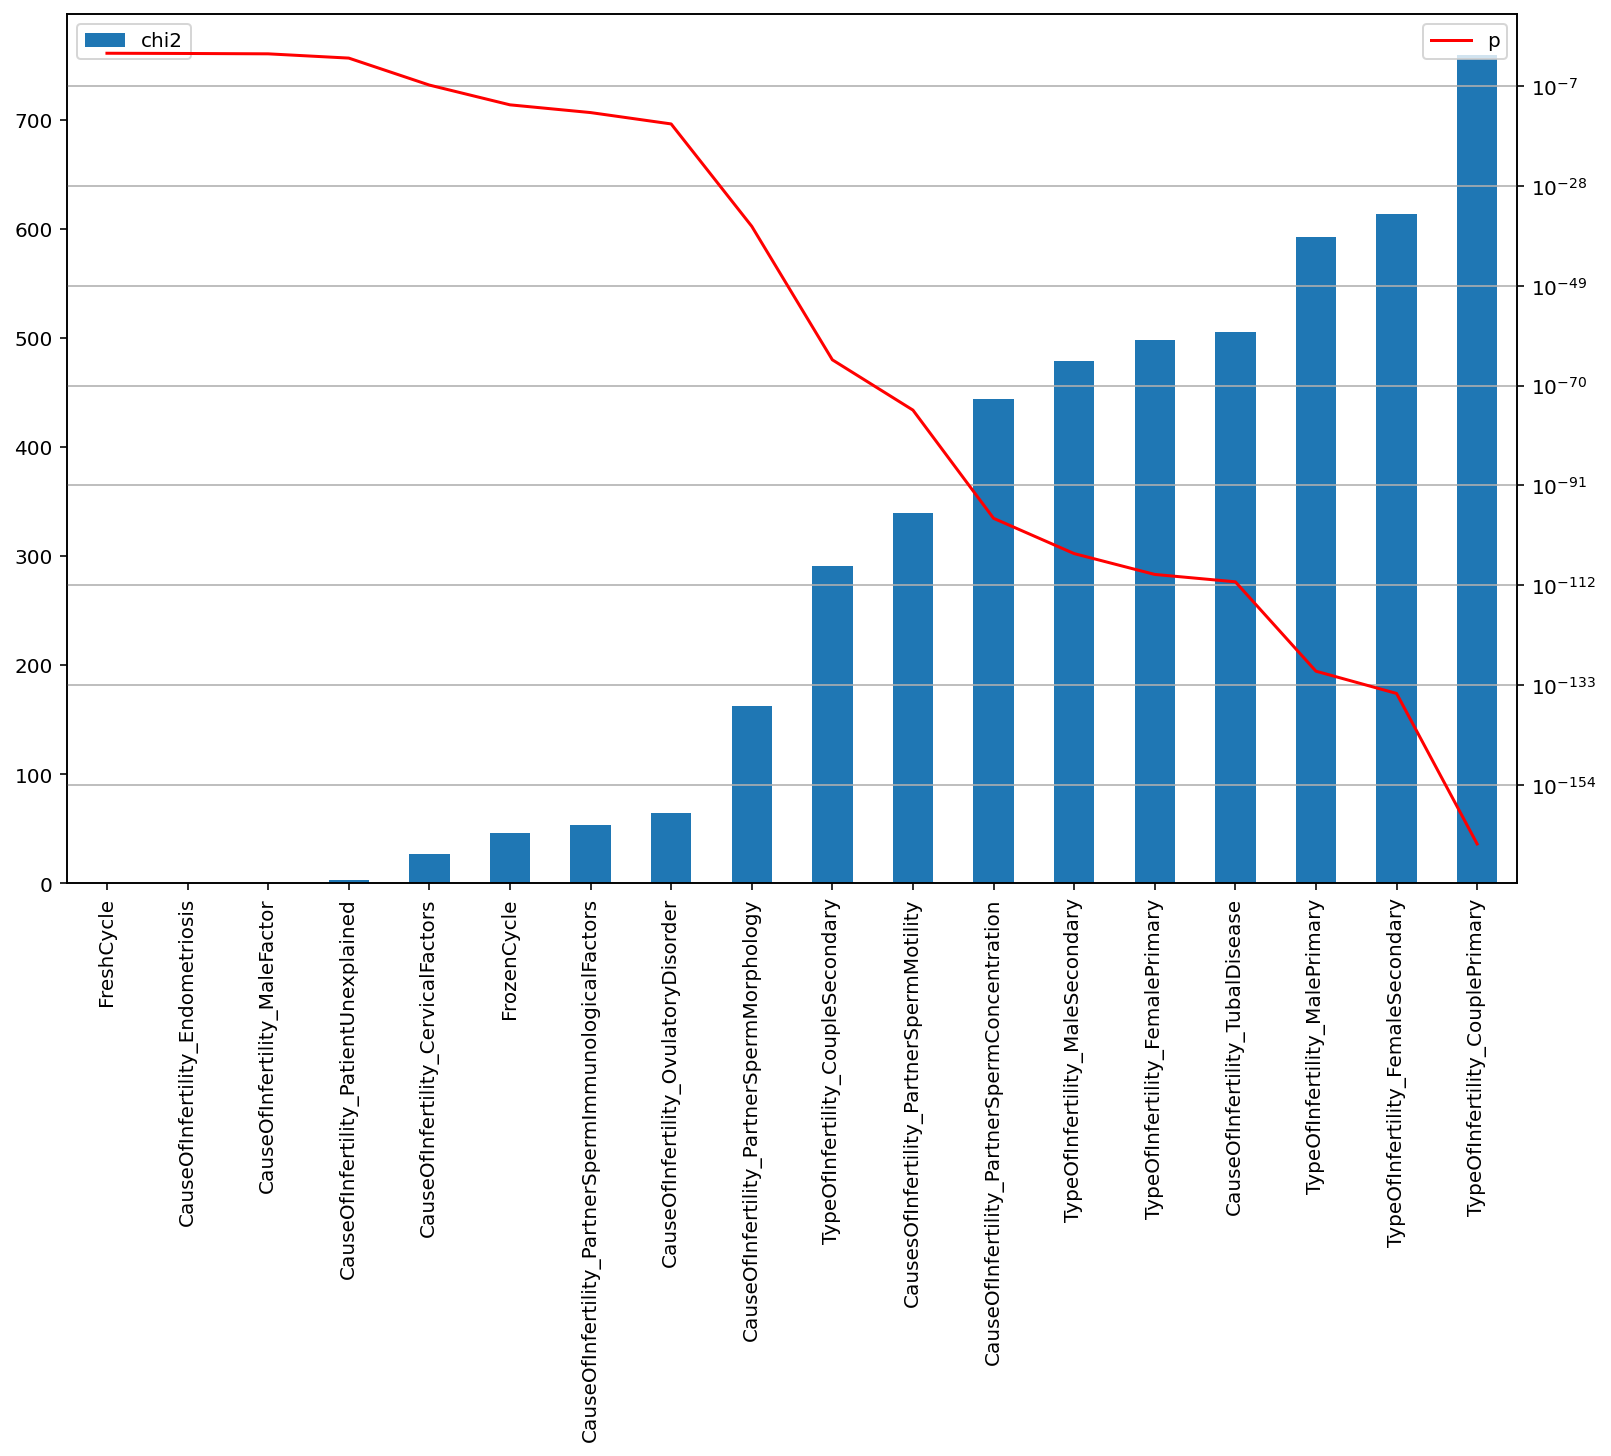

In [10]:
tmp = ds_set.apply(lambda x: len(x.unique()))
tmp = tmp[(tmp == 2)].index
tmp = ds_set[tmp].dropna(axis=1).columns
chi_result = chi2(ds_set[tmp], ds_set['LiveBirthOccurrence'])
chi_result = pd.DataFrame(chi_result, index=['chi2', 'p'], columns=tmp).T
chi_result = chi_result.drop(index='LiveBirthOccurrence')
chi_result = chi_result.sort_values('chi2')
ax = chi_result.plot.bar(y='chi2')
ax = plt.twinx(ax)
chi_result.plot.line(y='p', ax=ax, color='red', logy=True, grid=True)

In [64]:
# features = [
#     'PatientAgeAtTreatment', 'TypeOfInfertility_FemalePrimary',
#     'TypeOfInfertility_FemaleSecondary', 'TypeOfInfertility_MalePrimary',
#     'TypeOfInfertility_MaleSecondary', 'TypeOfInfertility_CouplePrimary',
#     'TypeOfInfertility_CoupleSecondary', 'CauseOfInfertility_TubalDisease',
#     'CauseOfInfertility_OvulatoryDisorder', 'CauseOfInfertility_MaleFactor',
#     'CauseOfInfertility_PatientUnexplained',
#     'CauseOfInfertility_Endometriosis', 'CauseOfInfertility_CervicalFactors',
#     'CauseOfInfertility_PartnerSpermConcentration',
#     'CauseOfInfertility_PartnerSpermMorphology',
#     'CausesOfInfertility_PartnerSpermMotility',
#     'CauseOfInfertility_PartnerSpermImmunologicalFactors', 
#     'FrozenCycle',
#     'EggsThawed', 'FreshEggsCollected', 'EggsMixedWithPartnerSperm',
#     'EmbryosTransfered'
# ]
features = [
    'PatientAgeAtTreatment', 'TypeOfInfertility_FemalePrimary',
    'TypeOfInfertility_FemaleSecondary', 'TypeOfInfertility_MalePrimary',
    'TypeOfInfertility_MaleSecondary', 'TypeOfInfertility_CouplePrimary',
    'TypeOfInfertility_CoupleSecondary', 'CauseOfInfertility_TubalDisease',
    'CauseOfInfertility_OvulatoryDisorder', 'CauseOfInfertility_MaleFactor',
    'CauseOfInfertility_PatientUnexplained',
    'CauseOfInfertility_Endometriosis', 'CauseOfInfertility_CervicalFactors',
    'CauseOfInfertility_PartnerSpermConcentration',
    'CauseOfInfertility_PartnerSpermMorphology',
    'CausesOfInfertility_PartnerSpermMotility',
    'CauseOfInfertility_PartnerSpermImmunologicalFactors', 
    'FreshEggsCollected', 'EggsMixedWithPartnerSperm',
    'EmbryosTransfered'
]
features=[
    'PatientAgeAtTreatment',
    
    'TotalNumberOfPreviousIvfCycles',
    'TotalNumberOfIvfPregnancies',
    'TotalNumberOfLiveBirths_ConceivedThroughIvf',
    
    
    'TypeOfInfertility_FemalePrimary',
#     'TypeOfInfertility_FemaleSecondary',
    'TypeOfInfertility_MalePrimary',
#     'TypeOfInfertility_MaleSecondary',
#     'TypeOfInfertility_CouplePrimary',
#     'TypeOfInfertility_CoupleSecondary',
    
    'CauseOfInfertility_TubalDisease',
    'CauseOfInfertility_OvulatoryDisorder',
#     'CauseOfInfertility_MaleFactor',
#     'CauseOfInfertility_PatientUnexplained',
#     'CauseOfInfertility_Endometriosis',
    'CauseOfInfertility_CervicalFactors',
#     'CauseOfInfertility_FemaleFactors',
    'CauseOfInfertility_PartnerSpermConcentration',
    'CauseOfInfertility_PartnerSpermMorphology',
    'CausesOfInfertility_PartnerSpermMotility',
#     'CauseOfInfertility_PartnerSpermImmunologicalFactors',
    
    'FreshCycle',
    'FreshEggsCollected',
#     'TotalEggsMixed',
#     'TotalEmbryosCreated',
    'EmbryosTransfered',
#     'ElectiveSingleEmbryoTransfer'
]
# features = [
#     'PatientAgeAtTreatment', 
#     'EggsMixedWithPartnerSperm',
#     'EmbryosTransfered'
# ]
target = 'LiveBirthOccurrence'

In [65]:
models = []
base_model = RandomForestClassifier(n_estimators=100,min_samples_leaf=5e-4,verbose=1,n_jobs=-1)
# base_model = LogisticRegressionCV(verbose=1,max_iter=1000,n_jobs=-1)
# base_model = GradientBoostingClassifier(n_estimators=1000,verbose=1)
# base_model=MLPClassifier((64,32,16),max_iter=1000,verbose=True)
for fold in StratifiedKFold(10,shuffle=True,random_state=0).split(ds_set,ds_set.LiveBirthOccurrence):
    mo = ModelObj(base_model,fold[0],fold[1],features,target)
    models.append(mo)
    break
_=[x.fit(ds_set) for x in models]

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    6.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.1s finished


In [67]:
models[0].save('mvp_model.dill')

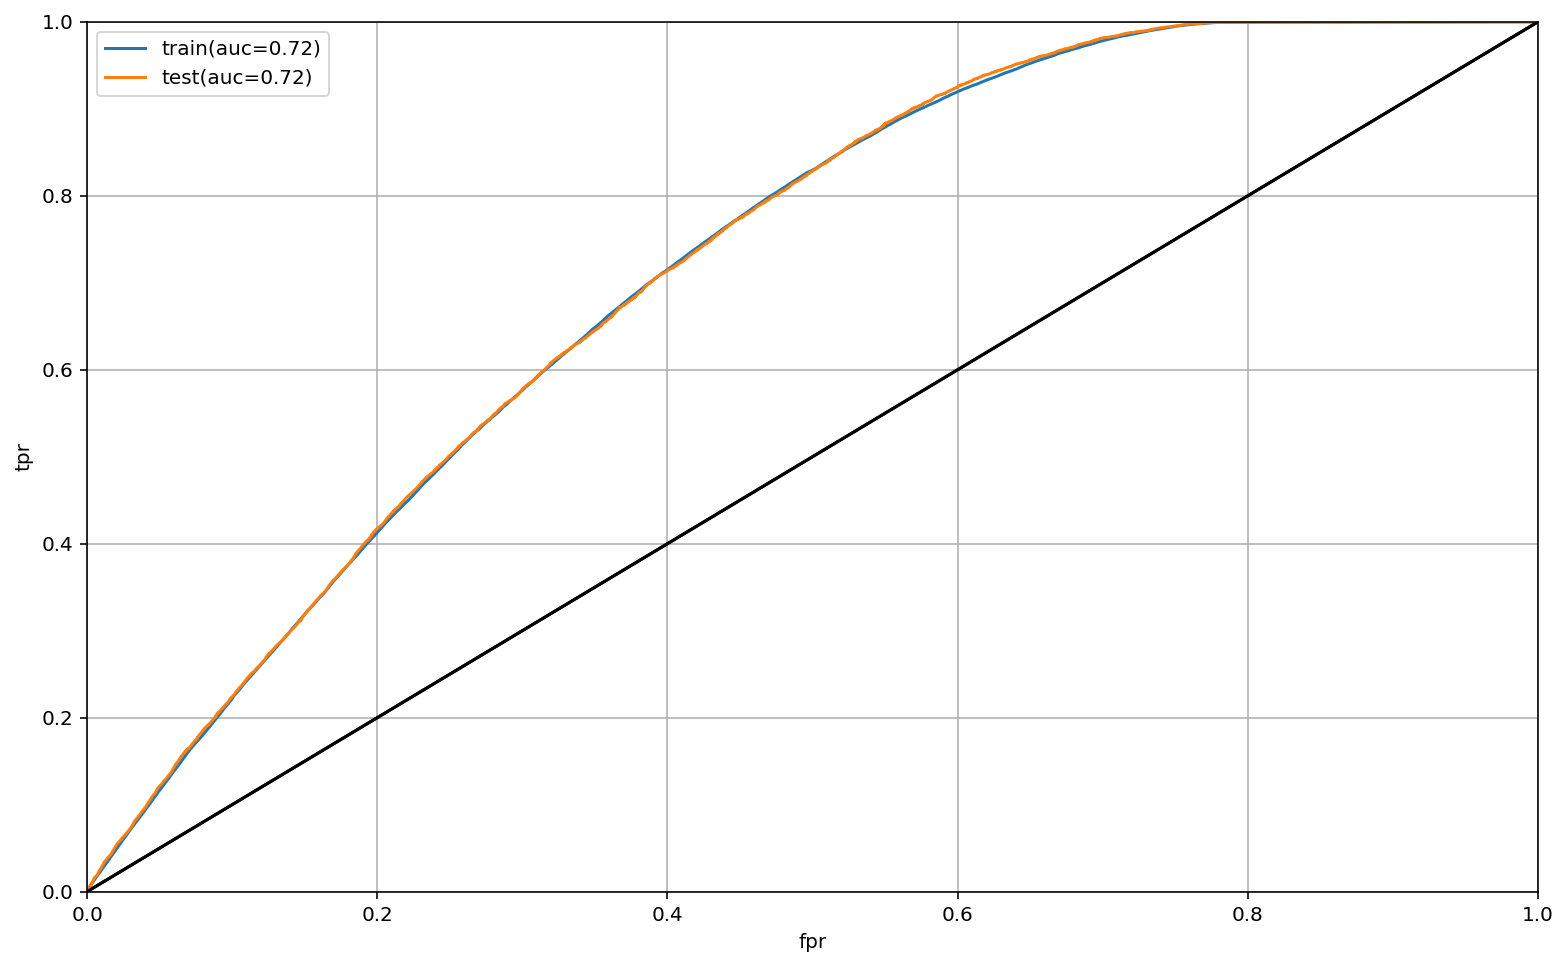

In [66]:
m_ = models[0]

plot_roc(m_.y_train,m_.p_train[:,1],label='train')
plot_roc(m_.y_test,m_.p_test[:,1],label='test')

<AxesSubplot:>

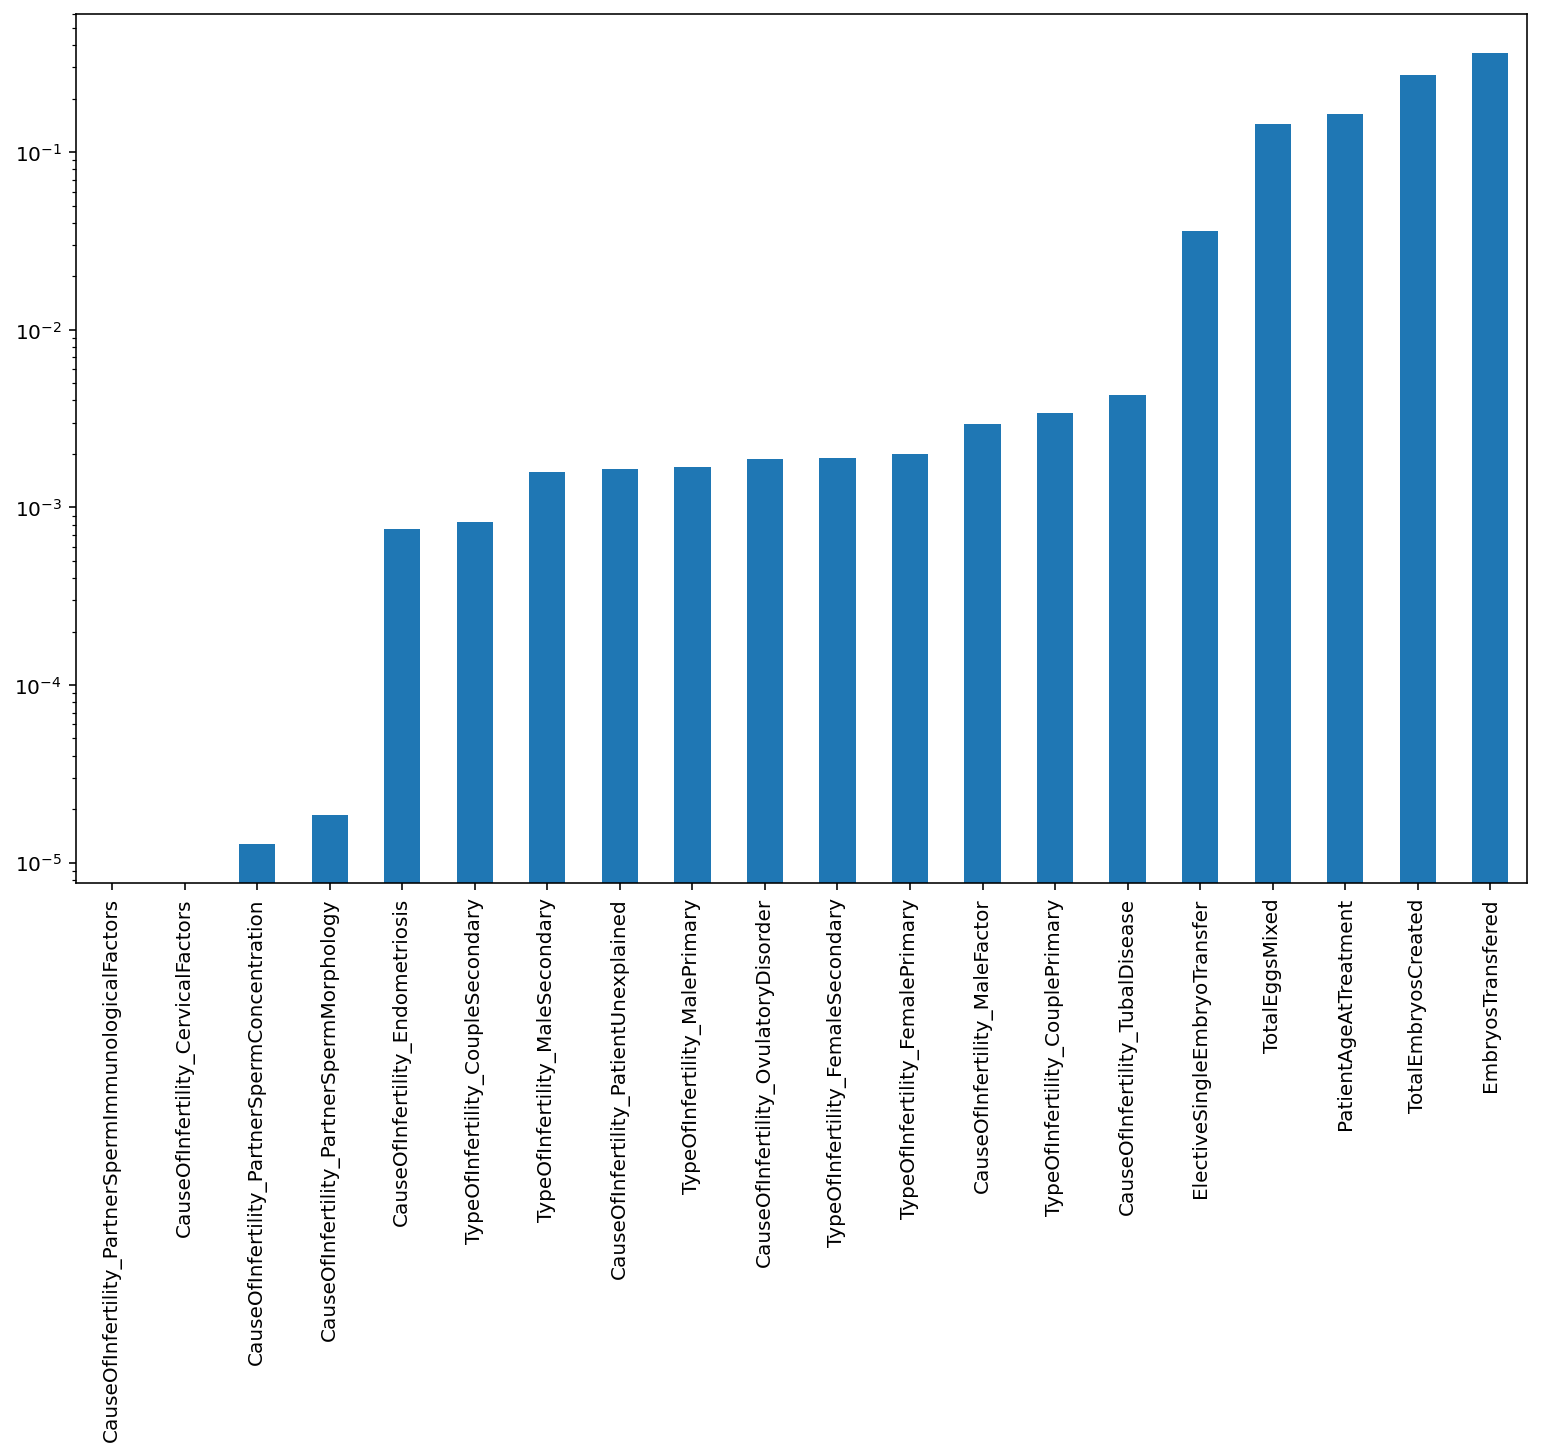

In [12]:
tmp=models[0].model.feature_importances_
tmp = pd.Series(tmp,index=features)
tmp.sort_values().plot.bar(logy=True)

In [99]:
model_bank = {
    'Logistic Regression':LogisticRegressionCV(verbose=1,n_jobs=-1),
    'Decision Tree':DecisionTreeClassifier(min_samples_leaf=5e-2),
    'LDA':LinearDiscriminantAnalysis(),
    'Random Forest':RandomForestClassifier(n_estimators=100,min_samples_leaf=5e-4,verbose=1,n_jobs=-1),
    'Gradient Boosting':GradientBoostingClassifier(n_estimators=200,verbose=1)
}

In [100]:
trained = {}
fold=StratifiedKFold(10, shuffle=True,random_state=0) 
fold = fold.split(ds_set, ds_set.LiveBirthOccurrence)
fold = next(fold)
for model_name, model in model_bank.items():
    trained[model_name] = ModelObj(model, fold[0], fold[1], features, target)
    trained[model_name].fit(ds_set)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   25.4s remaining:   38.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   31.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    8.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.1s finished


      Iter       Train Loss   Remaining Time 
         1           1.0942            1.19m
         2           1.0782            1.18m
         3           1.0645            1.15m
         4           1.0525            1.14m
         5           1.0423            1.13m
         6           1.0331            1.13m
         7           1.0253            1.13m
         8           1.0183            1.11m
         9           1.0121            1.11m
        10           1.0067            1.10m
        20           0.9760            1.02m
        30           0.9647           57.48s
        40           0.9597           55.61s
        50           0.9571           52.36s
        60           0.9556           48.58s
        70           0.9547           44.79s
        80           0.9540           41.07s
        90           0.9536           37.51s
       100           0.9532           34.00s
       200           0.9516            0.00s


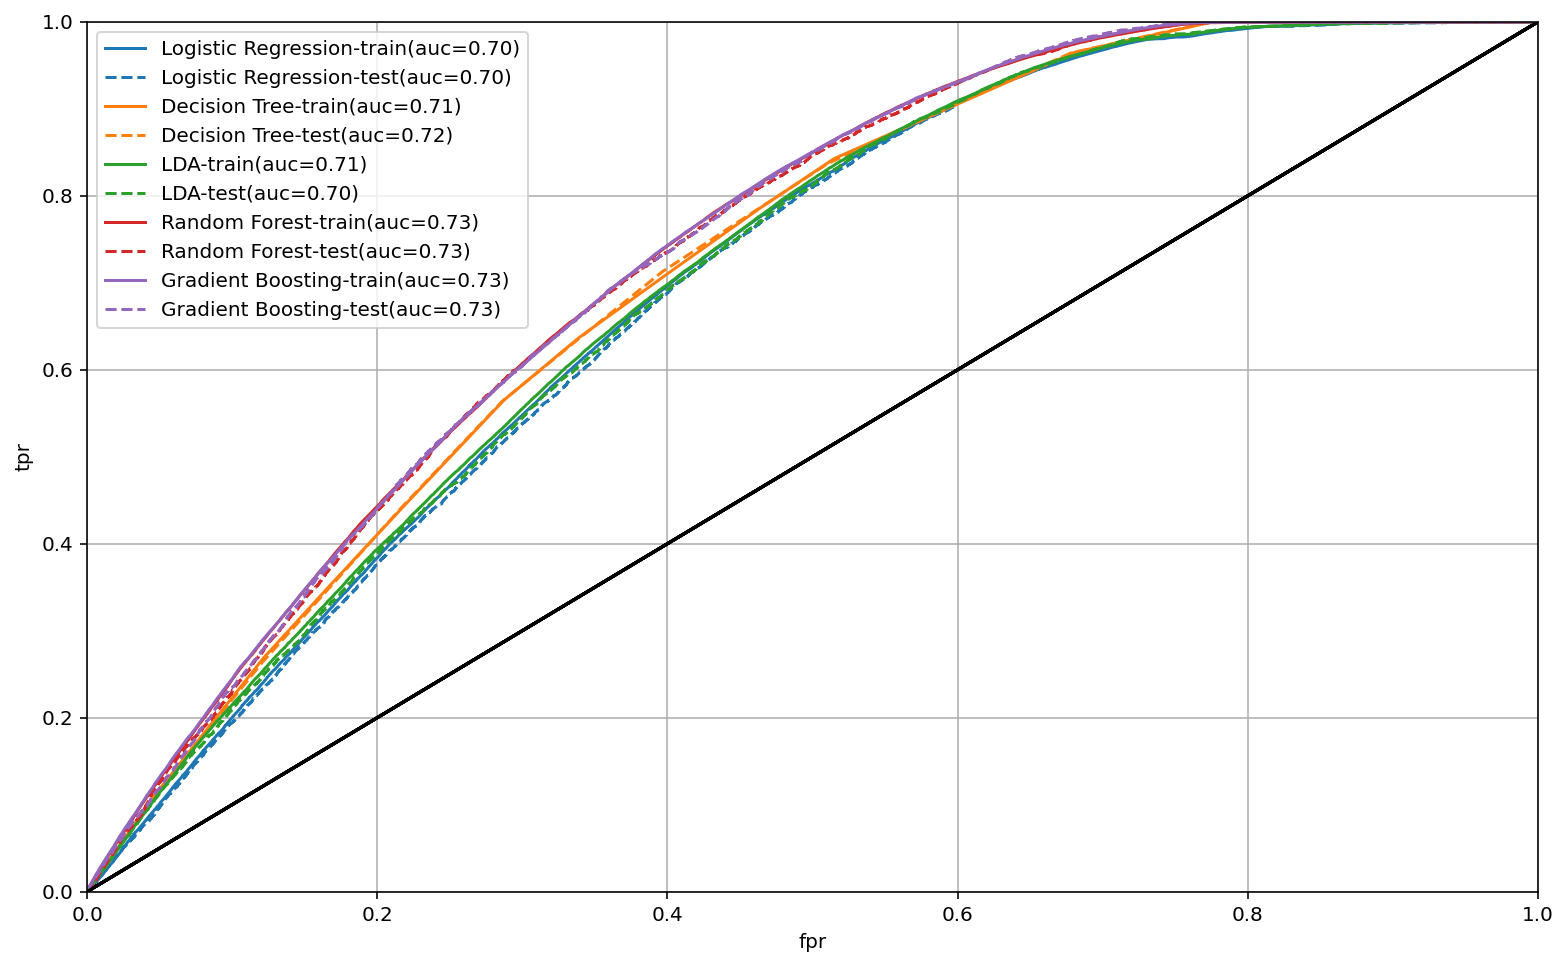

In [101]:
color_set = iter(matplotlib.cm.tab10.colors)
for model_name, model in trained.items():
    c_ = next(color_set)
    plot_roc(model.y_train,model.p_train[:,-1],label=f'{model_name}-train',color=c_,linestyle='-')
    plot_roc(model.y_test,model.p_test[:,-1],label=f'{model_name}-test',color=c_,linestyle='--')
    

In [110]:
inp = keras.layers.Input(shape=(len(features)))
relu_args = dict(activation='selu',kernel_initializer='lecun_normal')
selu_args = dict(activation='relu',kernel_initializer='he_normal')
tanh_args = dict(activation='tanh',kernel_initializer='glorot_normal')

l = keras.layers.Dense(64,**tanh_args,kernel_regularizer=keras.regularizers.l2(1e-3))(inp)
# l = keras.layers.Dense(128,**tanh_args,kernel_regularizer=keras.regularizers.l2(1e-3))(l)
l = keras.layers.Dense(32,**tanh_args,kernel_regularizer=keras.regularizers.l2(1e-3))(l)
out = keras.layers.Dense(1, activation='sigmoid')(l)

model = keras.Model(inputs=inp, outputs=out)
model.compile(optimizer='adadelta',loss='binary_crossentropy')
pip_ = make_pipeline(MinMaxScaler(),model)
mo = KerasModelObj(pip_, fold[0], fold[1], features, target)
# model.fit(ds_set.iloc[fold[0]][features].values,ds_set.iloc[fold[0]][target].values)

mo.fit(ds_set, train_args={'batch_size': 64,'epochs':500,'shuffle':True}, copy_model=False)

Epoch 1/500
4303/4303 [==============================] - 7s 2ms/step - loss: 0.6969 - val_loss: 0.6490
Epoch 2/500
4303/4303 [==============================] - 6s 1ms/step - loss: 0.6433 - val_loss: 0.6161
Epoch 3/500
4303/4303 [==============================] - 6s 1ms/step - loss: 0.6134 - val_loss: 0.5965
Epoch 4/500
4303/4303 [==============================] - 6s 1ms/step - loss: 0.5975 - val_loss: 0.5848
Epoch 5/500
4303/4303 [==============================] - 5s 1ms/step - loss: 0.5844 - val_loss: 0.5774
Epoch 6/500
4303/4303 [==============================] - 7s 2ms/step - loss: 0.5794 - val_loss: 0.5724
Epoch 7/500
4303/4303 [==============================] - 7s 2ms/step - loss: 0.5746 - val_loss: 0.5688
Epoch 8/500
4303/4303 [==============================] - 6s 1ms/step - loss: 0.5711 - val_loss: 0.5660
Epoch 9/500
4303/4303 [==============================] - 6s 1ms/step - loss: 0.5685 - val_loss: 0.5637
Epoch 10/500
4303/4303 [==============================] - 6s 1ms/step - l

KeyboardInterrupt: 

In [ ]:
mo.history_plot()

In [ ]:
plot_roc(mo.y_train,mo.p_train,label='train')
plot_roc(mo.y_test,mo.p_test,label='test')

In [93]:
p_test = []
y_test = []
for m_ in models:
    p_test.append(m_.p_test[:,1][:,np.newaxis])
    y_test.append(m_.y_test.values[:,np.newaxis])
y_test=np.concatenate(y_test,axis=0)[:,0]
p_test = np.concatenate(p_test,axis=0)[:,0]
test_out=pd.DataFrame([p_test,y_test],index=['predict','truth']).T

In [112]:
def precision_range(y_true: np.ndarray, y_pred: np.ndarray):
    i_ = y_pred.argsort()
    y_true = y_true.copy()[i_]
    y_pred = y_pred.copy()[i_]
    prc = np.zeros_like(y_true)
    
    length = len(prc)
    for c_, v_ in enumerate(y_pred):
        prc[c_] = y_true[c_:].sum() / (length - c_)
    return [prc,y_pred]


prange,thr = precision_range(y_test,p_test)

In [113]:
prange.max()

0.5080645161290323

## Multi cycle 

In [46]:
ds_set = ds.copy()
tmp=ds_set.apply(lambda x:len(x.unique()))
ds_set=ds_set.drop(columns=tmp[tmp==1].index)

<AxesSubplot:>

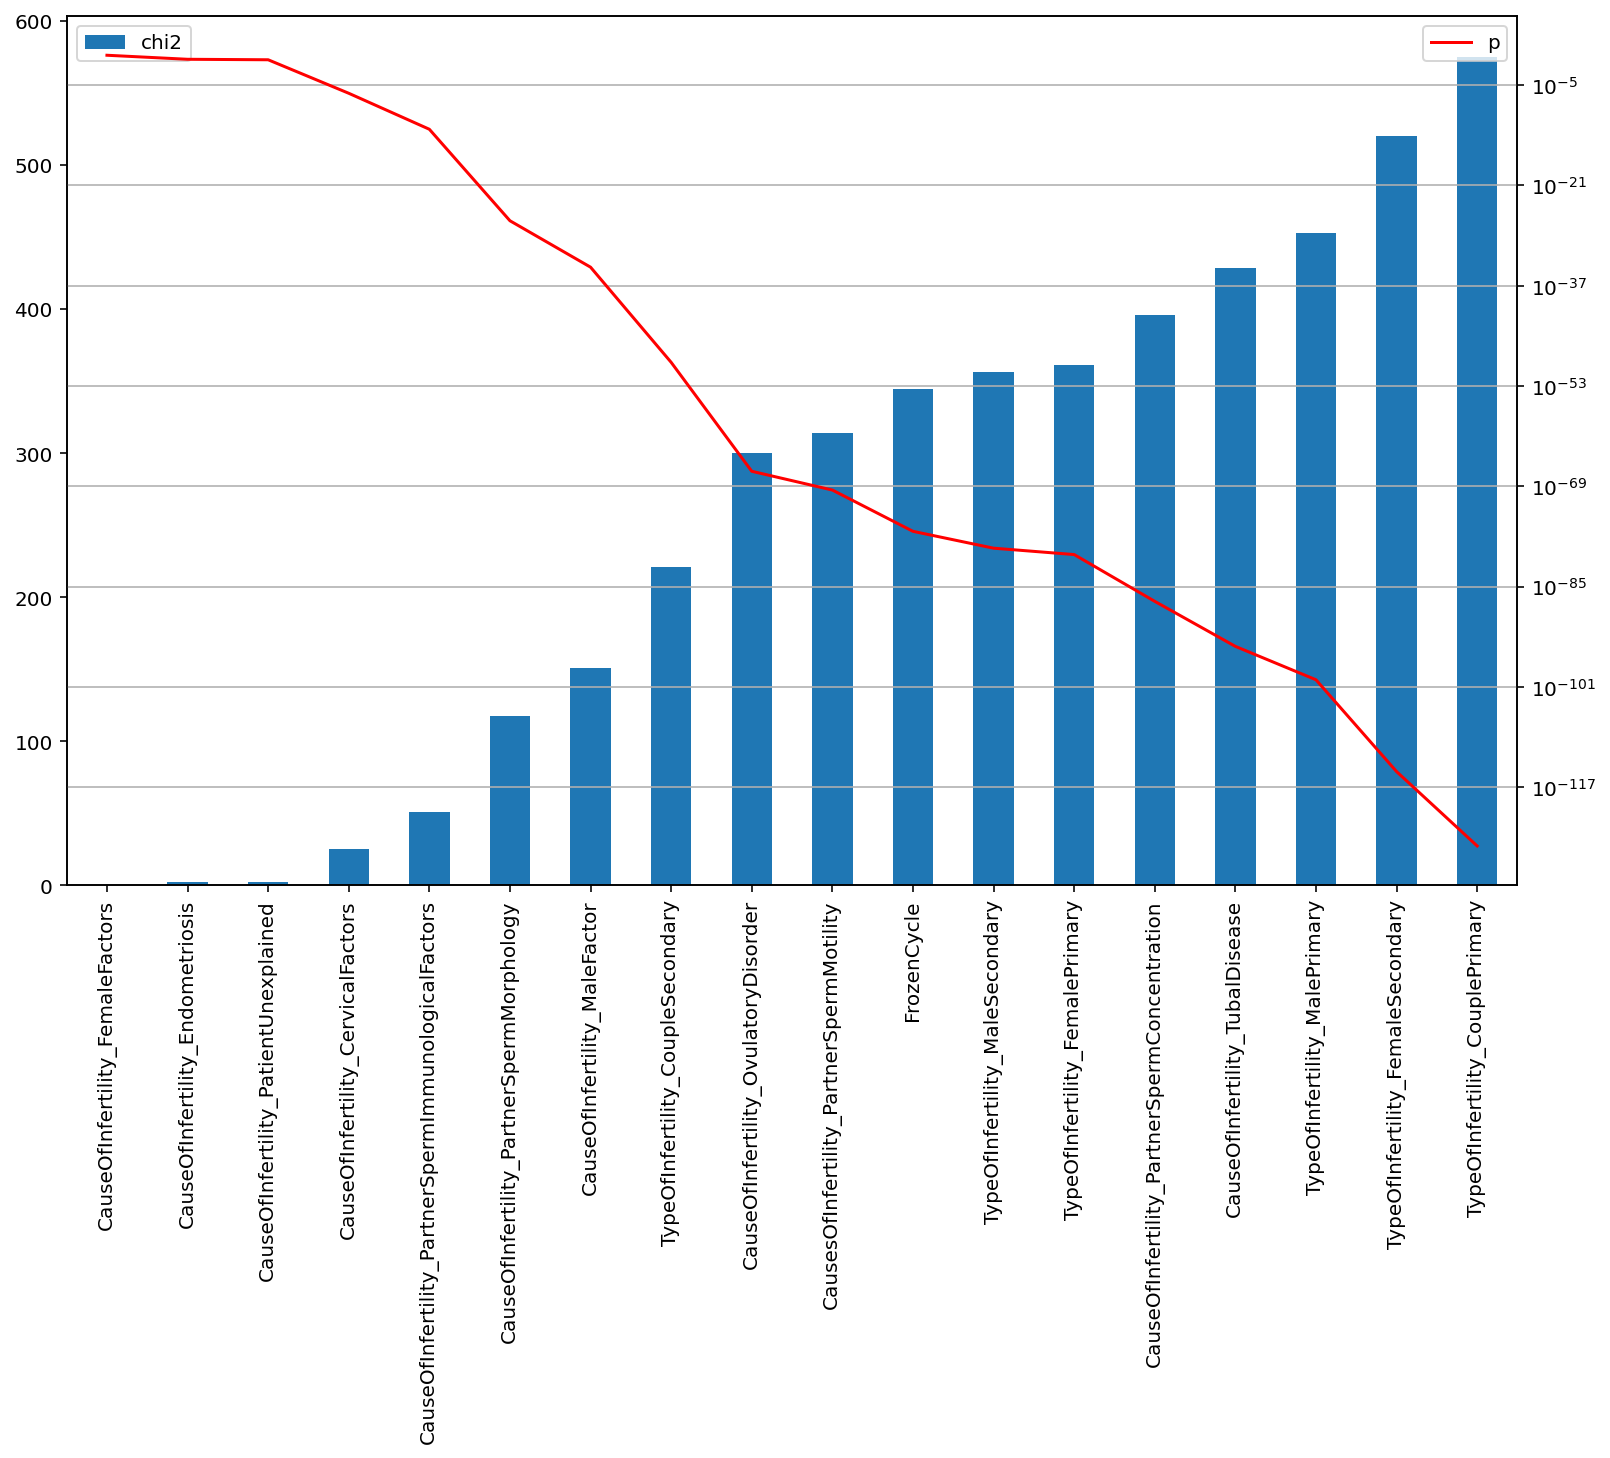

In [32]:
tmp = ds_set.apply(lambda x: len(x.unique()))
tmp = tmp[tmp == 2].index
chi_result = chi2(ds_set[tmp], ds_set['LiveBirthOccurrence'])
chi_result = pd.DataFrame(chi_result, index=['chi2', 'p'], columns=tmp).T
chi_result = chi_result.drop(index='LiveBirthOccurrence')
chi_result = chi_result.sort_values('chi2')
ax = chi_result.plot.bar(y='chi2')
ax = plt.twinx(ax)
chi_result.plot.line(y='p', ax=ax, color='red', logy=True, grid=True)

In [33]:
features = [
    'PatientAgeAtTreatment', 'TotalNumberOfPreviousIvfCycles',
    'TotalNumberOfIvfPregnancies',
    'TotalNumberOfLiveBirths_ConceivedThroughIvf',
    'TypeOfInfertility_FemalePrimary', 'TypeOfInfertility_FemaleSecondary',
    'TypeOfInfertility_MalePrimary', 'TypeOfInfertility_MaleSecondary',
    'TypeOfInfertility_CouplePrimary', 'TypeOfInfertility_CoupleSecondary',
    'CauseOfInfertility_TubalDisease', 'CauseOfInfertility_OvulatoryDisorder',
    'CauseOfInfertility_MaleFactor', 'CauseOfInfertility_PatientUnexplained',
    'CauseOfInfertility_Endometriosis', 'CauseOfInfertility_CervicalFactors',
    'CauseOfInfertility_PartnerSpermConcentration',
    'CauseOfInfertility_PartnerSpermMorphology',
    'CausesOfInfertility_PartnerSpermMotility',
    'CauseOfInfertility_PartnerSpermImmunologicalFactors', 'FrozenCycle',
    'EggsThawed', 'FreshEggsCollected', 'EggsMixedWithPartnerSperm',
    'EmbryosTransfered'
]
target = 'LiveBirthOccurrence'

In [36]:
models = []
base_model = RandomForestClassifier(verbose=1,min_samples_leaf=0.0001,n_jobs=-1)
# base_model = GradientBoostingClassifier(min_samples_leaf=0.0001,verbose=1)

for fold in StratifiedKFold(shuffle=True,random_state=0).split(ds_set,ds_set.LiveBirthOccurrence):
    mo = ModelObj(base_model,fold[0],fold[1],features,target)
    models.append(mo)
[x.fit(ds_set) for x in models]

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   19.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    1.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   19.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.5s
[Parallel

[None, None, None, None, None]

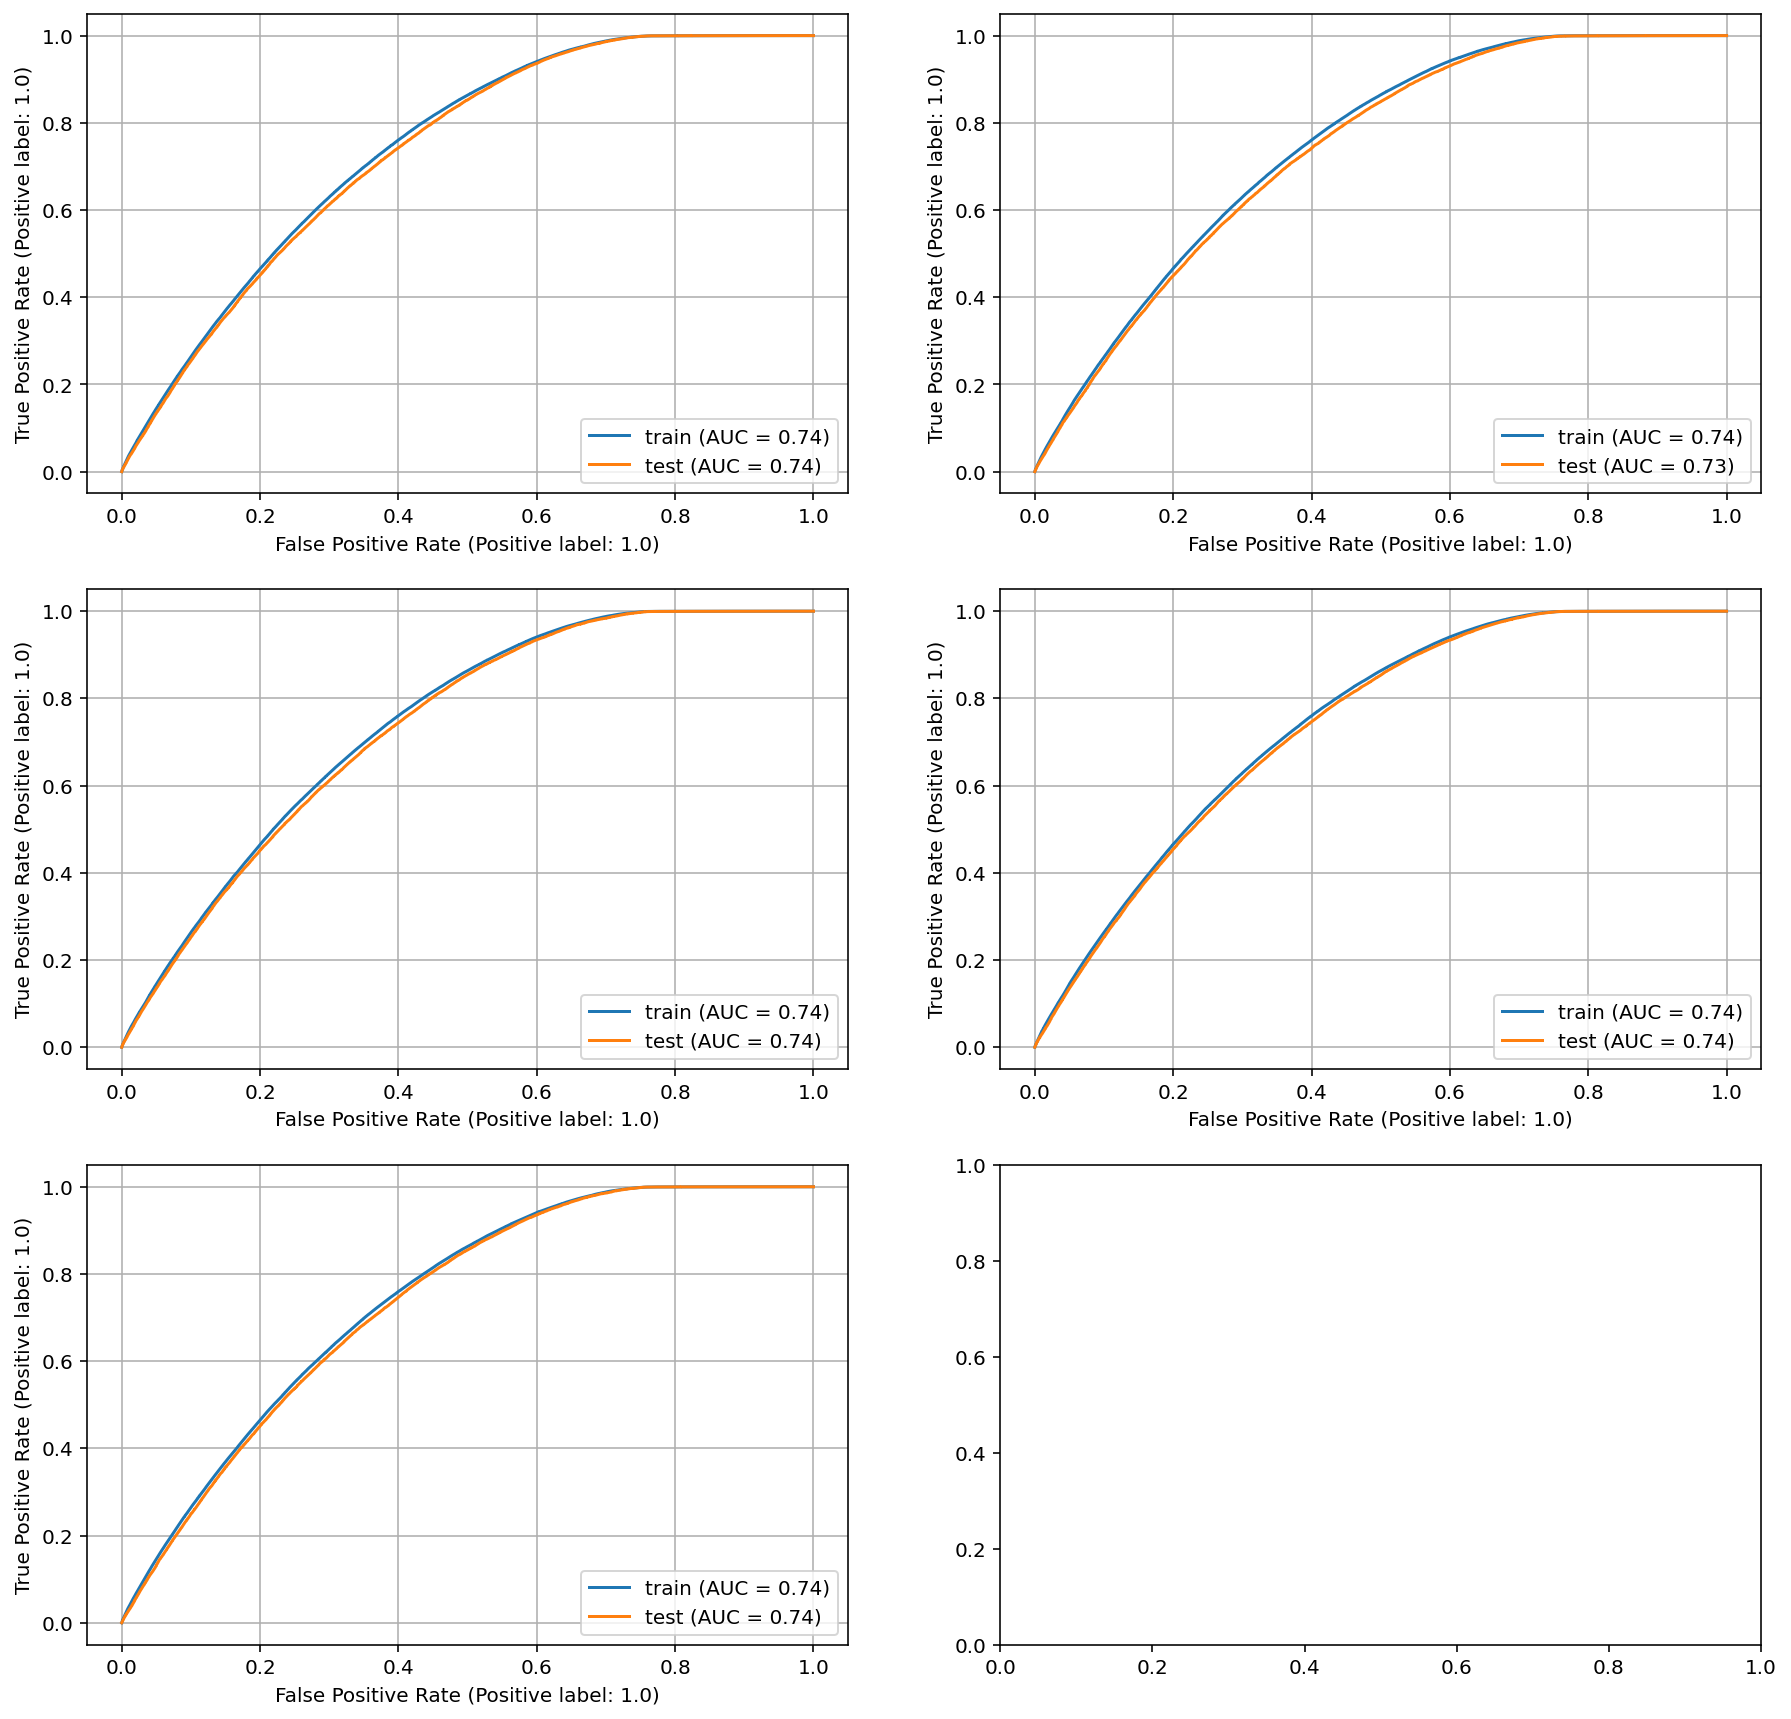

In [37]:
_,subs = plt.subplots(3,2,figsize=(15,5*3))
subs=subs.flatten()
for c_,m_ in enumerate(models):
    ax = subs[c_]
    m_.model.verbose=0
    plot_roc_curve(m_.model,m_.x_train,m_.y_train,ax=ax,name='train')
    plot_roc_curve(m_.model,m_.x_test,m_.y_test,ax=ax,name='test')
    ax.grid()

<AxesSubplot:>

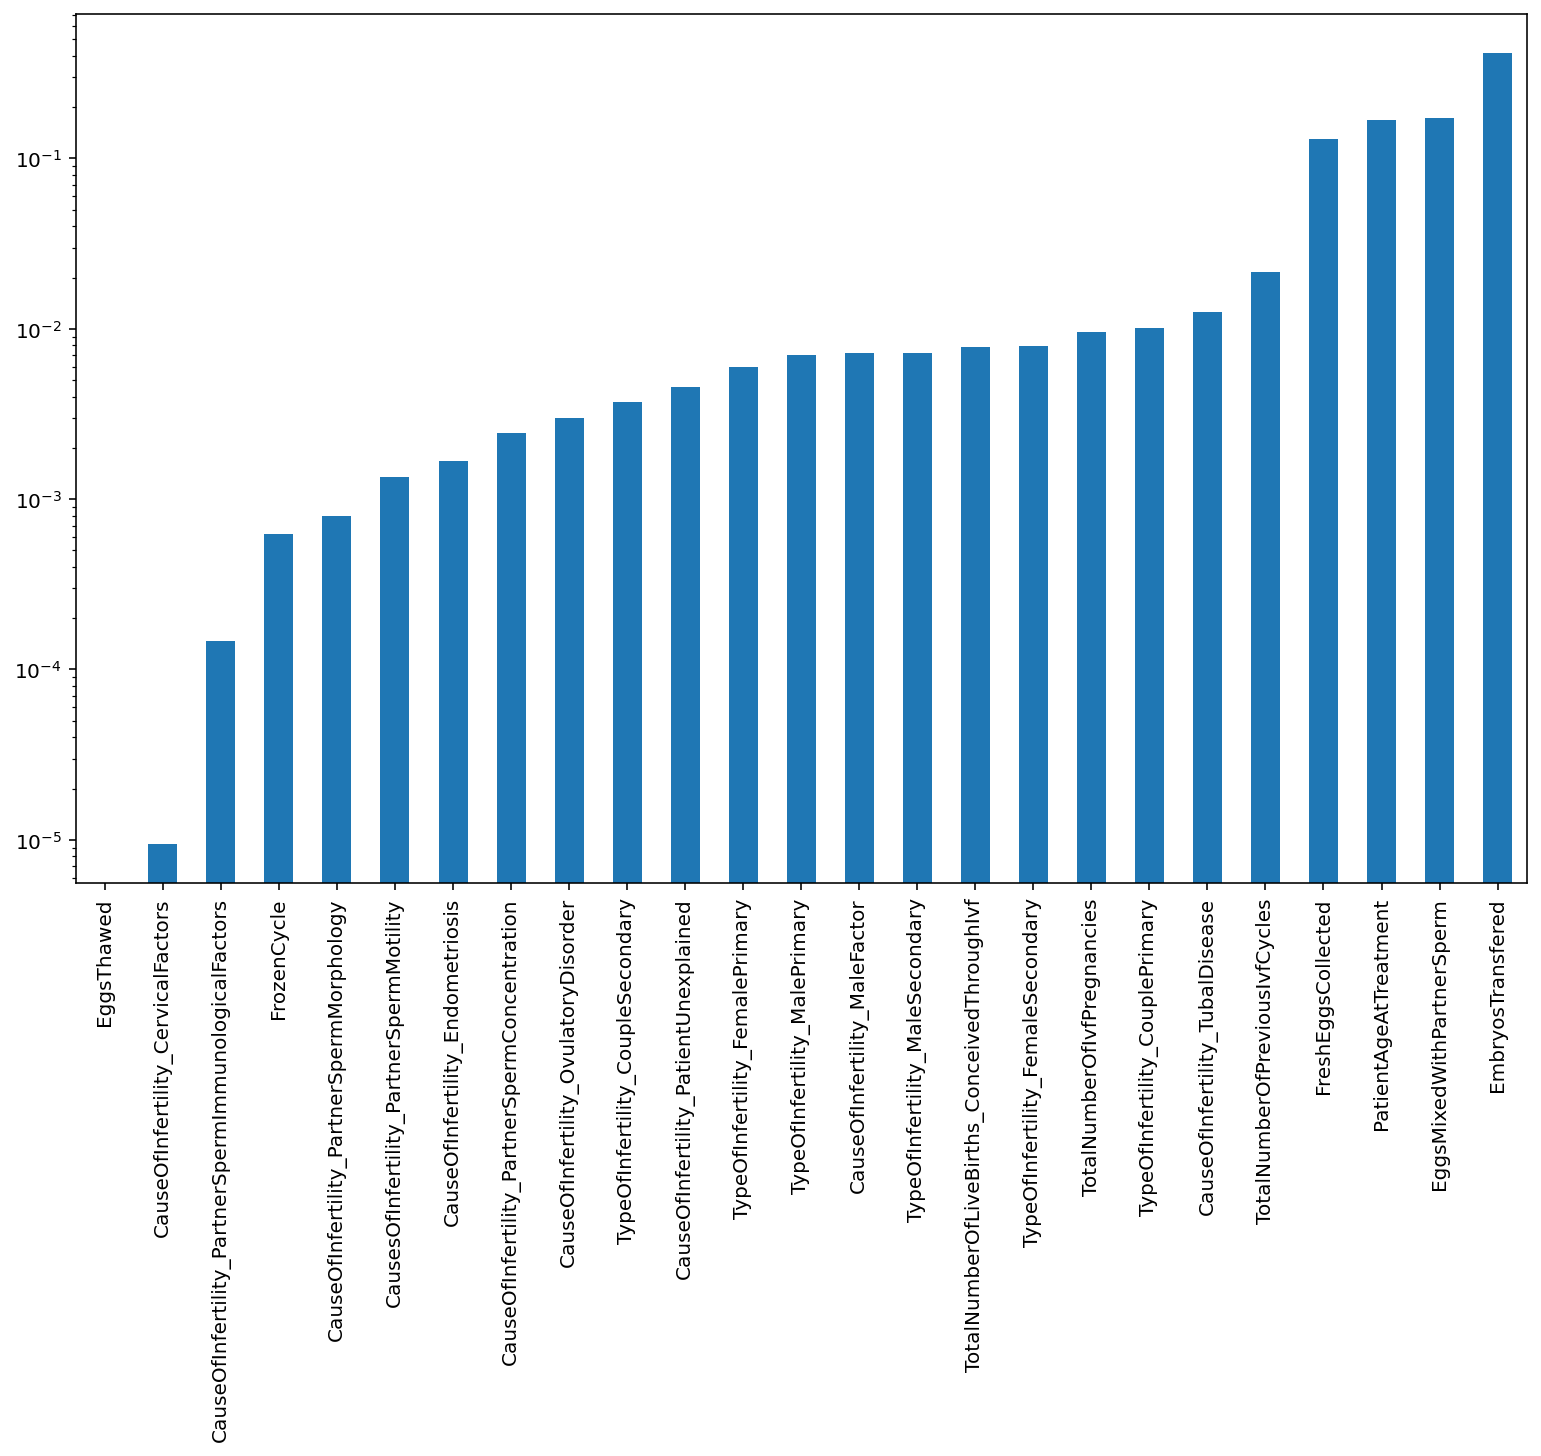

In [52]:
tmp=models[0].model.feature_importances_
tmp = pd.Series(tmp,index=features)
tmp.sort_values().plot.bar(logy=True)